In [31]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))

import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.model_xg import train_and_plot
from src.utils import compute_auc_roc

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()


from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

season = ["2023-24"]
pu = PlayerUtil(season)
scores = load_clean_scores(season)

scores.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,outperform_next_5,outperform_next_10,injured_next,injured,fantasyDiff
390948,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.25,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,0,1,False,False,0.0,0,-8.85
390949,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,0,0,False,False,1.0,1,-11.60
390950,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.40,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,0,1,True,False,0.0,0,-4.85
390951,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.50,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,0,1,True,True,0.0,0,-15.80
390952,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.00,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,0,0,False,False,1.0,1,-8.20


In [71]:
total_players = len(scores.personId.unique())
total_games = len(scores.gameId.unique())

total_games, total_players

(1215, 580)

## Player Minutes

In [66]:
mdf = pu.player_minute_stats()
mdf.sort_values('avg_minutes_per_game', ascending=False).iloc[:150]['avg_minutes_per_game'].mean()

30.78035753981976

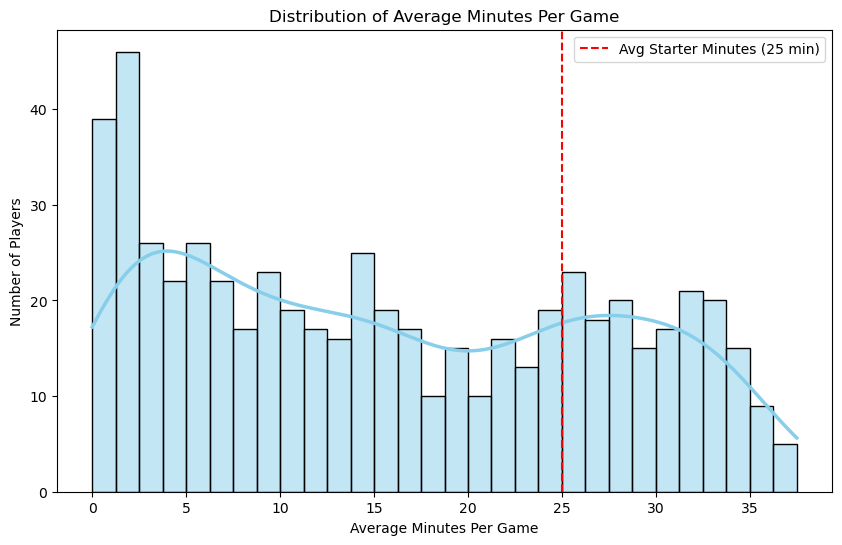

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

starter_threshold = 25

plt.figure(figsize=(10, 6))
sns.histplot(mdf["avg_minutes_per_game"], bins=30, kde=True, color="skyblue", line_kws={"linewidth": 2.5})
plt.axvline(
    starter_threshold, color="red", linestyle="--", label=f"Avg Starter Minutes ({starter_threshold} min)"
)
plt.title("Distribution of Average Minutes Per Game")
plt.xlabel("Average Minutes Per Game")
plt.ylabel("Number of Players")
plt.legend()
plt.show()

## Player Skill Variation

In [73]:
mdf.sort_values('avg_minutes_per_game')

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,games_over_10_minutes,total_games
216,2023-24,1629015,zhaire smith,0.000000,0,0,2
434,2023-24,1630792,malcolm hill,0.000000,0,0,6
106,2023-24,1626159,justise winslow,0.000000,0,0,1
236,2023-24,1629232,kaiser gates,0.000000,0,0,1
483,2023-24,1631209,isaiah wong,0.000000,0,0,4
...,...,...,...,...,...,...,...
254,2023-24,1629632,coby white,36.386325,78,78,78
4,2023-24,201142,kevin durant,36.706667,74,74,75
143,2023-24,1627832,fred vanvleet,36.727315,72,72,72
21,2023-24,201942,demar derozan,37.267300,78,78,79


In [109]:
mdf = pu.player_minute_stats()

mdf = mdf[mdf['avg_minutes_per_game'] > 1]
top_players = mdf.sort_values('avg_minutes_per_game', ascending=False).iloc[10:20]
bot_players = mdf.sort_values('avg_minutes_per_game', ascending=True).iloc[300:310]

In [110]:
bot_players

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,games_over_10_minutes,total_games
126,2023-24,1627739,kris dunn,17.021759,62,58,72
480,2023-24,1631204,marcus sasser,17.141775,69,54,77
53,2023-24,203083,andre drummond,17.265598,78,75,78
287,2023-24,1629723,john konchar,17.280303,48,45,66
219,2023-24,1629021,moritz wagner,17.309053,79,76,81
350,2023-24,1630285,zavier simpson,17.341667,6,5,8
523,2023-24,1641711,gradey dick,17.446244,54,50,71
412,2023-24,1630610,dejon jarreau,17.506250,8,7,8
240,2023-24,1629599,amir coffey,17.587037,63,60,81
121,2023-24,1626224,cedi osman,17.613380,71,68,71


In [82]:
top_players

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,games_over_10_minutes,total_games
73,2023-24,203507,giannis antetokounmpo,35.258796,72,72,72
391,2023-24,1630567,scottie barnes,35.230508,59,59,59
187,2023-24,1628970,miles bridges,35.153653,68,68,73
292,2023-24,1630162,anthony edwards,35.067308,77,77,78
438,2023-24,1631094,paolo banchero,34.983122,79,79,79
33,2023-24,202681,kyrie irving,34.957018,57,57,57
186,2023-24,1628969,mikal bridges,34.931276,81,81,81
52,2023-24,203081,damian lillard,34.904566,72,72,73
97,2023-24,203999,nikola jokic,34.689103,78,78,78
19,2023-24,201935,james harden,34.644601,71,71,71


In [112]:
selected_players = ['dwight powell', 'justin holiday', 'seth curry', 'andre drummond', 'cedi osman'] + ['lebron james', 'james harden',"giannis antetokounmpo", 'scottie barnes', 'miles bridges', 'kyrie irving']

In [113]:
cols = [
    "season_year",
    "game_date",
    "gameId",
    "matchup",
    "teamName",
    "teamSlug",
    "personId",
    "personName",
    "minutes",
    "fantasyPoints",
    "fantasyDiff",
]

df = scores[cols]
df = df[df["fantasyPoints"] != 0]
grouped_stats = (
    df.groupby(["personId", "personName"])
    .agg(
        mean_fantasyPoints=("fantasyPoints", "mean"),
        median_fantasyPoints=("fantasyPoints", "median"),
        std_fantasyPoints=("fantasyPoints", "std"),
    )
    .reset_index()
).dropna()


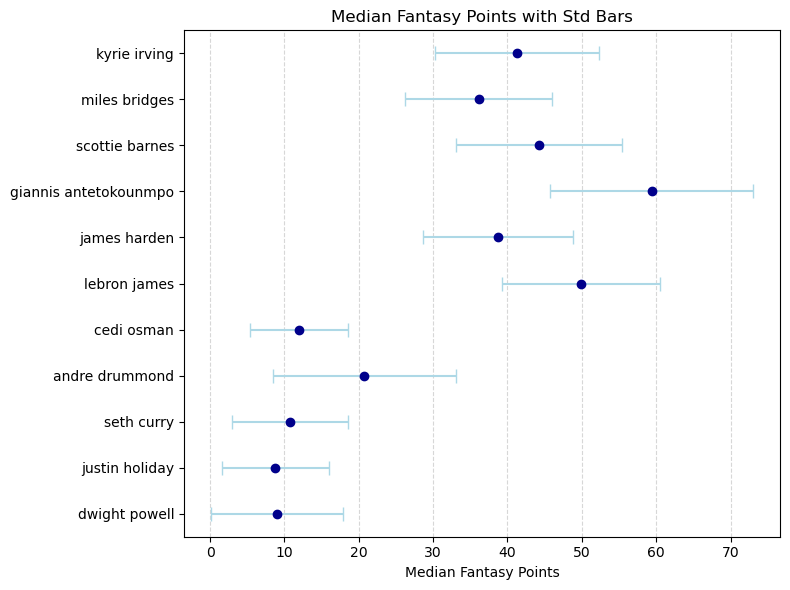

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter grouped_stats for selected players
filtered_stats = grouped_stats[
    grouped_stats["personName"].isin(selected_players)
].copy()

filtered_stats["personName"] = pd.Categorical(
    filtered_stats["personName"], categories=selected_players, ordered=True
)
filtered_stats = filtered_stats.sort_values("personName")

# Set up the plot
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=filtered_stats["median_fantasyPoints"],  # Median points
    y=filtered_stats["personName"],  # Player names on y-axis
    xerr=filtered_stats["std_fantasyPoints"],  # std bars
    fmt="o",  # Single points as circles
    color="darkblue",
    ecolor="lightblue",
    capsize=5,
)

# Add labels and title
plt.xlabel("Median Fantasy Points")
plt.title("Median Fantasy Points with Std Bars")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [95]:
filtered_stats

,personId,personName,mean_fantasyPoints,median_fantasyPoints,std_fantasyPoints
33,202681,kyrie irving,42.425439,41.250,10.996039
59,203200,justin holiday,10.122449,8.750,7.198112
73,203507,giannis antetokounmpo,59.309028,59.375,13.637310
74,203552,seth curry,11.388889,10.750,7.829989
87,203939,dwight powell,11.614035,9.000,8.888580
185,1628970,miles bridges,37.823529,36.125,9.902515
385,1630567,scottie barnes,44.457627,44.250,11.167046


In [91]:
df[df.personId == 203507]['fantasyPoints'].describe()

count    72.000000
mean     59.309028
std      13.637310
min      24.500000
25%      50.250000
50%      59.375000
75%      68.562500
max      95.500000
Name: fantasyPoints, dtype: float64

## Join with Lookback

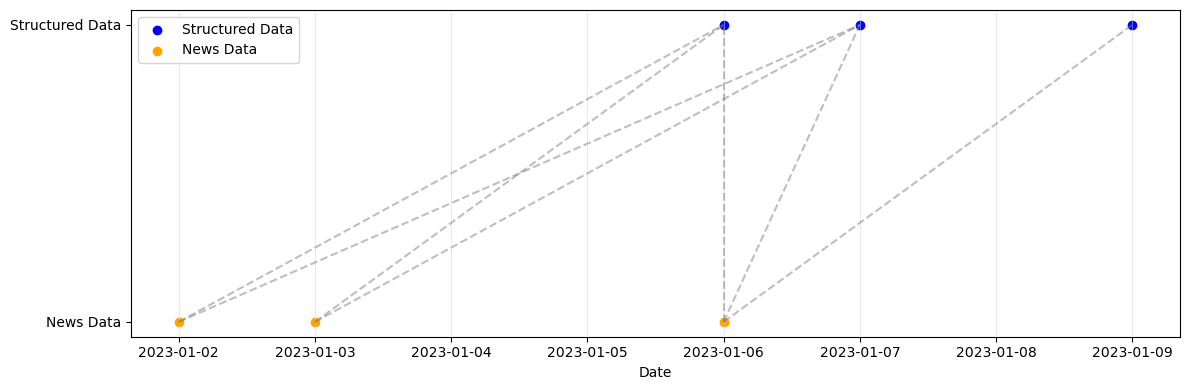

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data
structured_data = ["2023-01-06", "2023-01-07", "2023-01-09"]
news_data = ["2023-01-02", "2023-01-03", "2023-01-06"]

news_data = pd.to_datetime(news_data)
structured_data = pd.to_datetime(structured_data)

lookback_days = 5

# Generate the full date range
full_date_range = pd.date_range(
    min(news_data.min(), structured_data.min()),
    max(news_data.max(), structured_data.max()),
    freq="D",
)

# Plot
plt.figure(figsize=(12, 4))

# Draw lines for every day in the timeline
for date in full_date_range:
    plt.axvline(date, color="lightgray", linestyle="-", linewidth=0.5, alpha=0.7)

# Structured data
plt.scatter(
    structured_data, [1] * len(structured_data), label="Structured Data", color="blue"
)

# News data
plt.scatter(news_data, [0] * len(news_data), label="News Data", color="orange")

# Lookback arrows
for sd in structured_data:
    for nd in news_data:
        if 0 <= (sd - nd).days <= lookback_days:
            plt.plot([nd, sd], [0, 1], color="gray", linestyle="--", alpha=0.5)

plt.yticks([0, 1], ["News Data", "Structured Data"])
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()